In [1]:
from tensorflow.keras.applications import xception

model = xception.Xception(
    weights="imagenet",
    include_top=True
)

91897856/91884032 [==============================] - 2s 0us/step


In [2]:
from tensorflow.keras.utils import get_file, load_img, img_to_array
import numpy as np

# Preprocessing input for xception
img_path = get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

745472/733657 [==============================] - 0s 1us/step


In [3]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [7]:
# setting up a model that returns the last convolutional output
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions"
]

last_conv_layer = model.get_layer(last_conv_layer_name)

from tensorflow.keras.models import Model

last_conv_layer_model = Model(model.inputs, outputs=last_conv_layer.output)

In [8]:
# Reapplying the classifier on top of the last convolutional ouput
from tensorflow.keras.layers import Input

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)

classifier_model = Model(inputs=classifier_input, outputs=x)

In [9]:
# retrieving the gradients of the top predicted class
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_preds_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_preds_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [10]:
# gradient pooling and channel-importance weighting
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

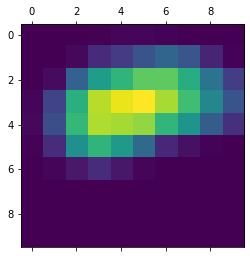

In [11]:
# heatmap post-processing
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

import matplotlib.pyplot as plt
plt.matshow(heatmap)

In [17]:
import matplotlib.cm as cm

img = load_img(img_path)
img = img_to_array(img)

# display heatmap on original picture
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

from tensorflow.keras.utils import array_to_img
jet_heatmap = array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

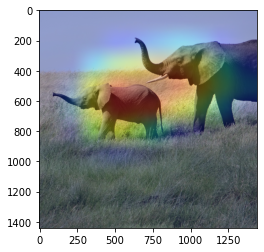

In [18]:
plt.imshow(superimposed_img)